In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

import numpy as onp

import paragami 

from vb_lib import structure_model_lib, data_utils, plotting_utils

import time

import matplotlib.pyplot as plt
%matplotlib inline  


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Files

In [2]:
# data_file = '../data/phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'
# out_filename = 'huang2011_fit'
# out_folder = '../fits/hgdp_fits/'

data_file = '../simulated_data/simulated_structure_data_nobs20_nloci50_npop4.npz' # file with the data
out_filename = 'testing' # name of fit
out_folder = '../fits/tmp/' # folder where fits are located

# Load data

In [3]:
data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

In [4]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

In [5]:
print(n_obs)
print(n_loci)

20
50


# Load fits

In [6]:
import os
import re

In [7]:
filenames = out_filename + '_alpha\d.'

In [8]:
files = [f for f in os.listdir(out_folder) if (re.match(filenames, f) and not f.endswith('lrderivatives.npz'))]

In [9]:
files

['testing_alpha7.5.npz',
 'testing_alpha11.0.npz',
 'testing_alpha2.0.npz',
 'testing_alpha6.5.npz',
 'testing_alpha10.0.npz',
 'testing_alpha3.0.npz',
 'testing_alpha9.5.npz',
 'testing_alpha5.5.npz',
 'testing_alpha8.5.npz',
 'testing_alpha4.5.npz',
 'testing_alpha1.0.npz',
 'testing_alpha3.5.npz',
 'testing_alpha10.5.npz',
 'testing_alpha6.0.npz',
 'testing_alpha2.5.npz',
 'testing_alpha7.0.npz',
 'testing_alpha1.5.npz',
 'testing_alpha4.0.npz',
 'testing_alpha8.0.npz',
 'testing_alpha5.0.npz',
 'testing_alpha9.0.npz']

### load first fit to get metadata

In [10]:
_, vb_params_paragami, \
    prior_params_dict, prior_params_paragami, \
        gh_loc, gh_weights, meta_data = \
            structure_model_lib.load_structure_fit(out_folder + files[0])

### load all fits

In [11]:
get_kl = jax.jit(lambda vb_params_dict, prior_params_dict : 
                     structure_model_lib.get_kl(g_obs, 
                                                vb_params_dict,
                                                prior_params_dict, 
                                                gh_loc, gh_weights))

In [12]:
vb_refit_list = []
alpha_vec = onp.zeros(len(files))
refit_times = []

for i in range(len(files)): 
    
    print('loading fit from: ', files[i])
    
    # load fit
    vb_params_dict, vb_params_paragami, meta_data = \
        paragami.load_folded(out_folder + files[i])
    
    # check KL
    prior_params_dict['dp_prior_alpha'] = np.array(meta_data['dp_prior_alpha'])
    
    kl = get_kl(vb_params_dict, prior_params_dict)
    
    assert np.abs(kl - meta_data['final_kl']) < 1e-8
    
    # save alpha and fitted parametrs
    alpha_vec[i] = meta_data['dp_prior_alpha']
    vb_refit_list.append(vb_params_paragami.flatten(vb_params_dict, free = True))
    
    # save refit timing 
    refit_times.append(meta_data['optim_time'])
    
alpha_vec = np.array(alpha_vec)
vb_refit_list = np.array(vb_refit_list)
refit_times = np.array(refit_times)

loading fit from:  testing_alpha7.5.npz
loading fit from:  testing_alpha11.0.npz
loading fit from:  testing_alpha2.0.npz
loading fit from:  testing_alpha6.5.npz
loading fit from:  testing_alpha10.0.npz
loading fit from:  testing_alpha3.0.npz
loading fit from:  testing_alpha9.5.npz
loading fit from:  testing_alpha5.5.npz
loading fit from:  testing_alpha8.5.npz
loading fit from:  testing_alpha4.5.npz
loading fit from:  testing_alpha1.0.npz
loading fit from:  testing_alpha3.5.npz
loading fit from:  testing_alpha10.5.npz
loading fit from:  testing_alpha6.0.npz
loading fit from:  testing_alpha2.5.npz
loading fit from:  testing_alpha7.0.npz
loading fit from:  testing_alpha1.5.npz
loading fit from:  testing_alpha4.0.npz
loading fit from:  testing_alpha8.0.npz
loading fit from:  testing_alpha5.0.npz
loading fit from:  testing_alpha9.0.npz


In [13]:
# for convencience, sort the alphas 
_indx = np.argsort(alpha_vec)
alpha_vec = alpha_vec[_indx]
vb_refit_list = vb_refit_list[_indx]
refit_times = refit_times[_indx]

In [14]:
alpha_vec

DeviceArray([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
              6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
             11. ], dtype=float64)

In [15]:
# no gaps 
np.all(np.diff(alpha_vec) == 0.5)

DeviceArray(True, dtype=bool)

# Expected number of clusters

In [16]:
seed = 2342
key = jax.random.PRNGKey(seed)

@jax.jit
def get_e_num_clusters(vb_params_dict): 
    # TODO this is super slow ...
    return 0.
#     return structure_model_lib.get_e_num_clusters(g_obs, vb_params_dict, gh_loc, gh_weights, 
#                                                    n_samples = 1000,
#                                                    threshold = n_obs * n_loci * 0.001,
#                                                    seed = seed)

@jax.jit
def get_e_num_pred_clusters(vb_params_dict): 
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return structure_model_lib.get_e_num_pred_clusters(stick_means, stick_infos, gh_loc, gh_weights, 
                                                            key = key, n_samples = 100)

In [17]:
def get_num_clusters_vec(vb_free_params_list, cluster_fun): 
    # vb_free_params_list contains an array of 
    # vb free parameters, where each row contains 
    # parameters from a different refit (or lr prediction)
    
    # cluster fun takes input a vb parameter dictionary 
    # and returns the posterior expectation of interest
    
    n_refit = len(vb_free_params_list)
    n_clusters_vec = onp.zeros(n_refit)
    
    for i in range(n_refit): 
        # print(i)
        # fold 
        vb_dict = vb_params_paragami.fold(vb_free_params_list[i], 
                                          free = True)

        # get number of clusters
        n_clusters_vec[i] = cluster_fun(vb_dict)
    
    return n_clusters_vec

In [18]:
refit_n_clusters_vec = get_num_clusters_vec(vb_refit_list, get_e_num_clusters)
refit_n_pred_clusters_vec = get_num_clusters_vec(vb_refit_list, get_e_num_pred_clusters)

Text(0, 0.5, 'num posterior pred clusters')

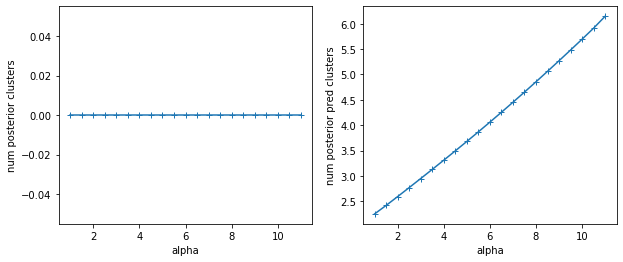

In [19]:
fig, axarr = plt.subplots(1, 2, figsize = (10, 4))

# plot in-sample results
axarr[0].plot(alpha_vec, refit_n_clusters_vec, '+-')

axarr[0].set_xlabel('alpha')
axarr[0].set_ylabel('num posterior clusters')

# plot posterior-predictive results
axarr[1].plot(alpha_vec, refit_n_pred_clusters_vec, '+-')

axarr[1].set_xlabel('alpha')
axarr[1].set_ylabel('num posterior pred clusters')

# Define the initial fit

In [20]:
alpha0 = 3.

which_fit = (alpha_vec == alpha0)

vb_opt = vb_refit_list[which_fit].squeeze()
vb_opt_dict = vb_params_paragami.fold(vb_opt,
                                      free = True)
prior_params_dict['dp_prior_alpha'] = alpha0

### Plot initial fit

Text(0.5, 0, 'Individuals')

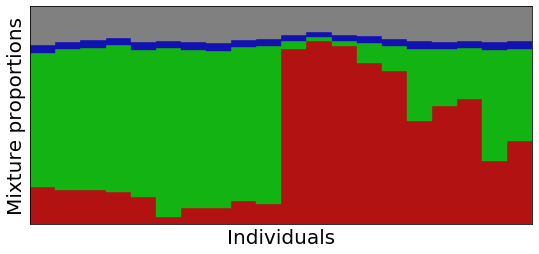

In [21]:
e_ind_admix = plotting_utils.get_vb_expectations(vb_params_dict, gh_loc, gh_weights)[0]
# re-order individuals for better plotting
indx = data_utils.cluster_admix_get_indx(e_ind_admix)

f, axarr = plt.subplots(1, 1, figsize=(9, 4))
e_ind_admix = plotting_utils.plot_top_clusters(e_ind_admix[indx], axarr, 
                                               n_top_clusters = 3)

axarr.set_ylabel('Mixture proportions', fontsize = 20)
axarr.set_xlabel('Individuals', fontsize = 20)

### Define linear response for initial fit

In [22]:
lr_file = [f for f in os.listdir(out_folder) \
           if (re.match(filenames, f) and f.endswith(str(alpha0) + '_lrderivatives.npz'))][0]

print('lr file: ', out_folder + lr_file)

lr_data = np.load(out_folder + lr_file)
assert lr_data['alpha0'] == alpha0
assert np.abs(lr_data['vb_opt'] - vb_opt).max() < 1e-12

print('derivative time: {:.3f}secs'.format(lr_data['lr_time_alpha']))

lr file:  ../fits/tmp/testing_alpha3.0_lrderivatives.npz
derivative time: 0.217secs


In [23]:
alpha0_free = prior_params_paragami['dp_prior_alpha'].\
                flatten(prior_params_dict['dp_prior_alpha'], free = True)

def predict_opt_par_from_hyper_par(alpha_pert): 
    alpha_pert_free = prior_params_paragami['dp_prior_alpha'].\
                flatten(alpha_pert, free = True)
    
    delta = alpha_pert_free - alpha0_free
        
    return vb_opt + lr_data['dinput_dalpha'] * delta

In [24]:
t0 = time.time()
lr_free_params_list = []
for i in range(len(alpha_vec)): 

    lr_free_params_list.append(predict_opt_par_from_hyper_par(alpha_vec[i]))

# computing the vb parameters are fast!
print('lr time: {:03f}secs'.format(time.time() - t0))

lr time: 0.134216secs


### Get linear reponse predictions

In [25]:
lr_n_clusters_vec = get_num_clusters_vec(lr_free_params_list, get_e_num_clusters)
lr_n_pred_clusters_vec = get_num_clusters_vec(lr_free_params_list, get_e_num_pred_clusters)

# at alpha zero, the lr should match exactly the refit 
indx = np.where(alpha_vec == alpha0)
assert lr_n_clusters_vec[indx] == \
        lr_n_clusters_vec[indx]

assert lr_n_pred_clusters_vec[indx] == \
        refit_n_pred_clusters_vec[indx]

# compare against refit results

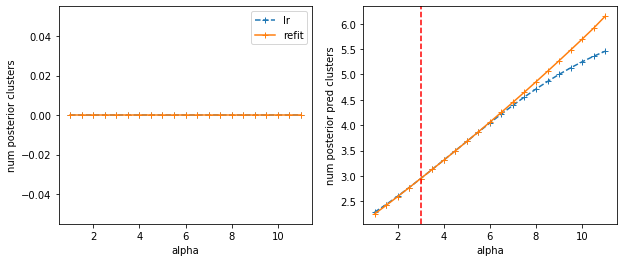

In [26]:
fig, axarr = plt.subplots(1, 2, figsize = (10, 4))

# plot in-sample results
axarr[0].plot(alpha_vec, lr_n_clusters_vec, '+--')
axarr[0].plot(alpha_vec, refit_n_clusters_vec, '+-')

axarr[0].set_xlabel('alpha')
axarr[0].set_ylabel('num posterior clusters')
axarr[0].legend(('lr', 'refit'))

# plot posterior-predictive results
axarr[1].plot(alpha_vec, lr_n_pred_clusters_vec, '+--')
axarr[1].plot(alpha_vec, refit_n_pred_clusters_vec, '+-')

axarr[1].set_xlabel('alpha')
axarr[1].set_ylabel('num posterior pred clusters')

plt.axvline(alpha0, color = 'red', linestyle = 'dashed')

# Print refit times

In [27]:
# recal LR time
print('derivative time: {:.3f}secs'.format(lr_data['lr_time_alpha']))

derivative time: 0.217secs


In [28]:
import pandas as pd

In [29]:
pd.DataFrame(data = {'refit times (sec)': refit_times, 
                     'alpha': alpha_vec}, 
            index = alpha_vec).sort_values('alpha')

,refit times (sec),alpha
1.0,3.701574,1.0
1.5,3.407201,1.5
2.0,3.180003,2.0
2.5,2.999882,2.5
3.0,2.923568,3.0
3.5,2.647772,3.5
4.0,2.604637,4.0
4.5,2.609495,4.5
5.0,2.475744,5.0
5.5,2.080049,5.5
